GPU Available: []
TensorFlow version: 2.19.0
🔋 ENHANCED EV FORECASTING: Anomaly Detection + Federated Learning
🚨 Simulating DDoS attacks with sustained high volume irregular spikes
🛡️ Comparing LSTM performance: Clean Data vs Anomalous Data vs Filtered Data

📊 Generating data for three EV charging stations with DDoS attacks...
Injecting DDoS attacks: 8.0% of data affected...
Successfully injected 691 attack points (8.0% of data)
Injecting DDoS attacks: 8.0% of data affected...
Successfully injected 691 attack points (8.0% of data)
Injecting DDoS attacks: 8.0% of data affected...
Successfully injected 691 attack points (8.0% of data)

📈 Attack Statistics:
  🏢 Client 1 (Business): 691 attacked points (8.0%)
  🛒 Client 2 (Shopping): 691 attacked points (8.0%)
  🏠 Client 3 (Residential): 691 attacked points (8.0%)

🛡️ Training Anomaly Detection Models for Each Client...
Training Client 1 anomaly detector...
Training autoencoder on normal data...
Building LSTM Autoencoder...
Epoch 1/50
173/

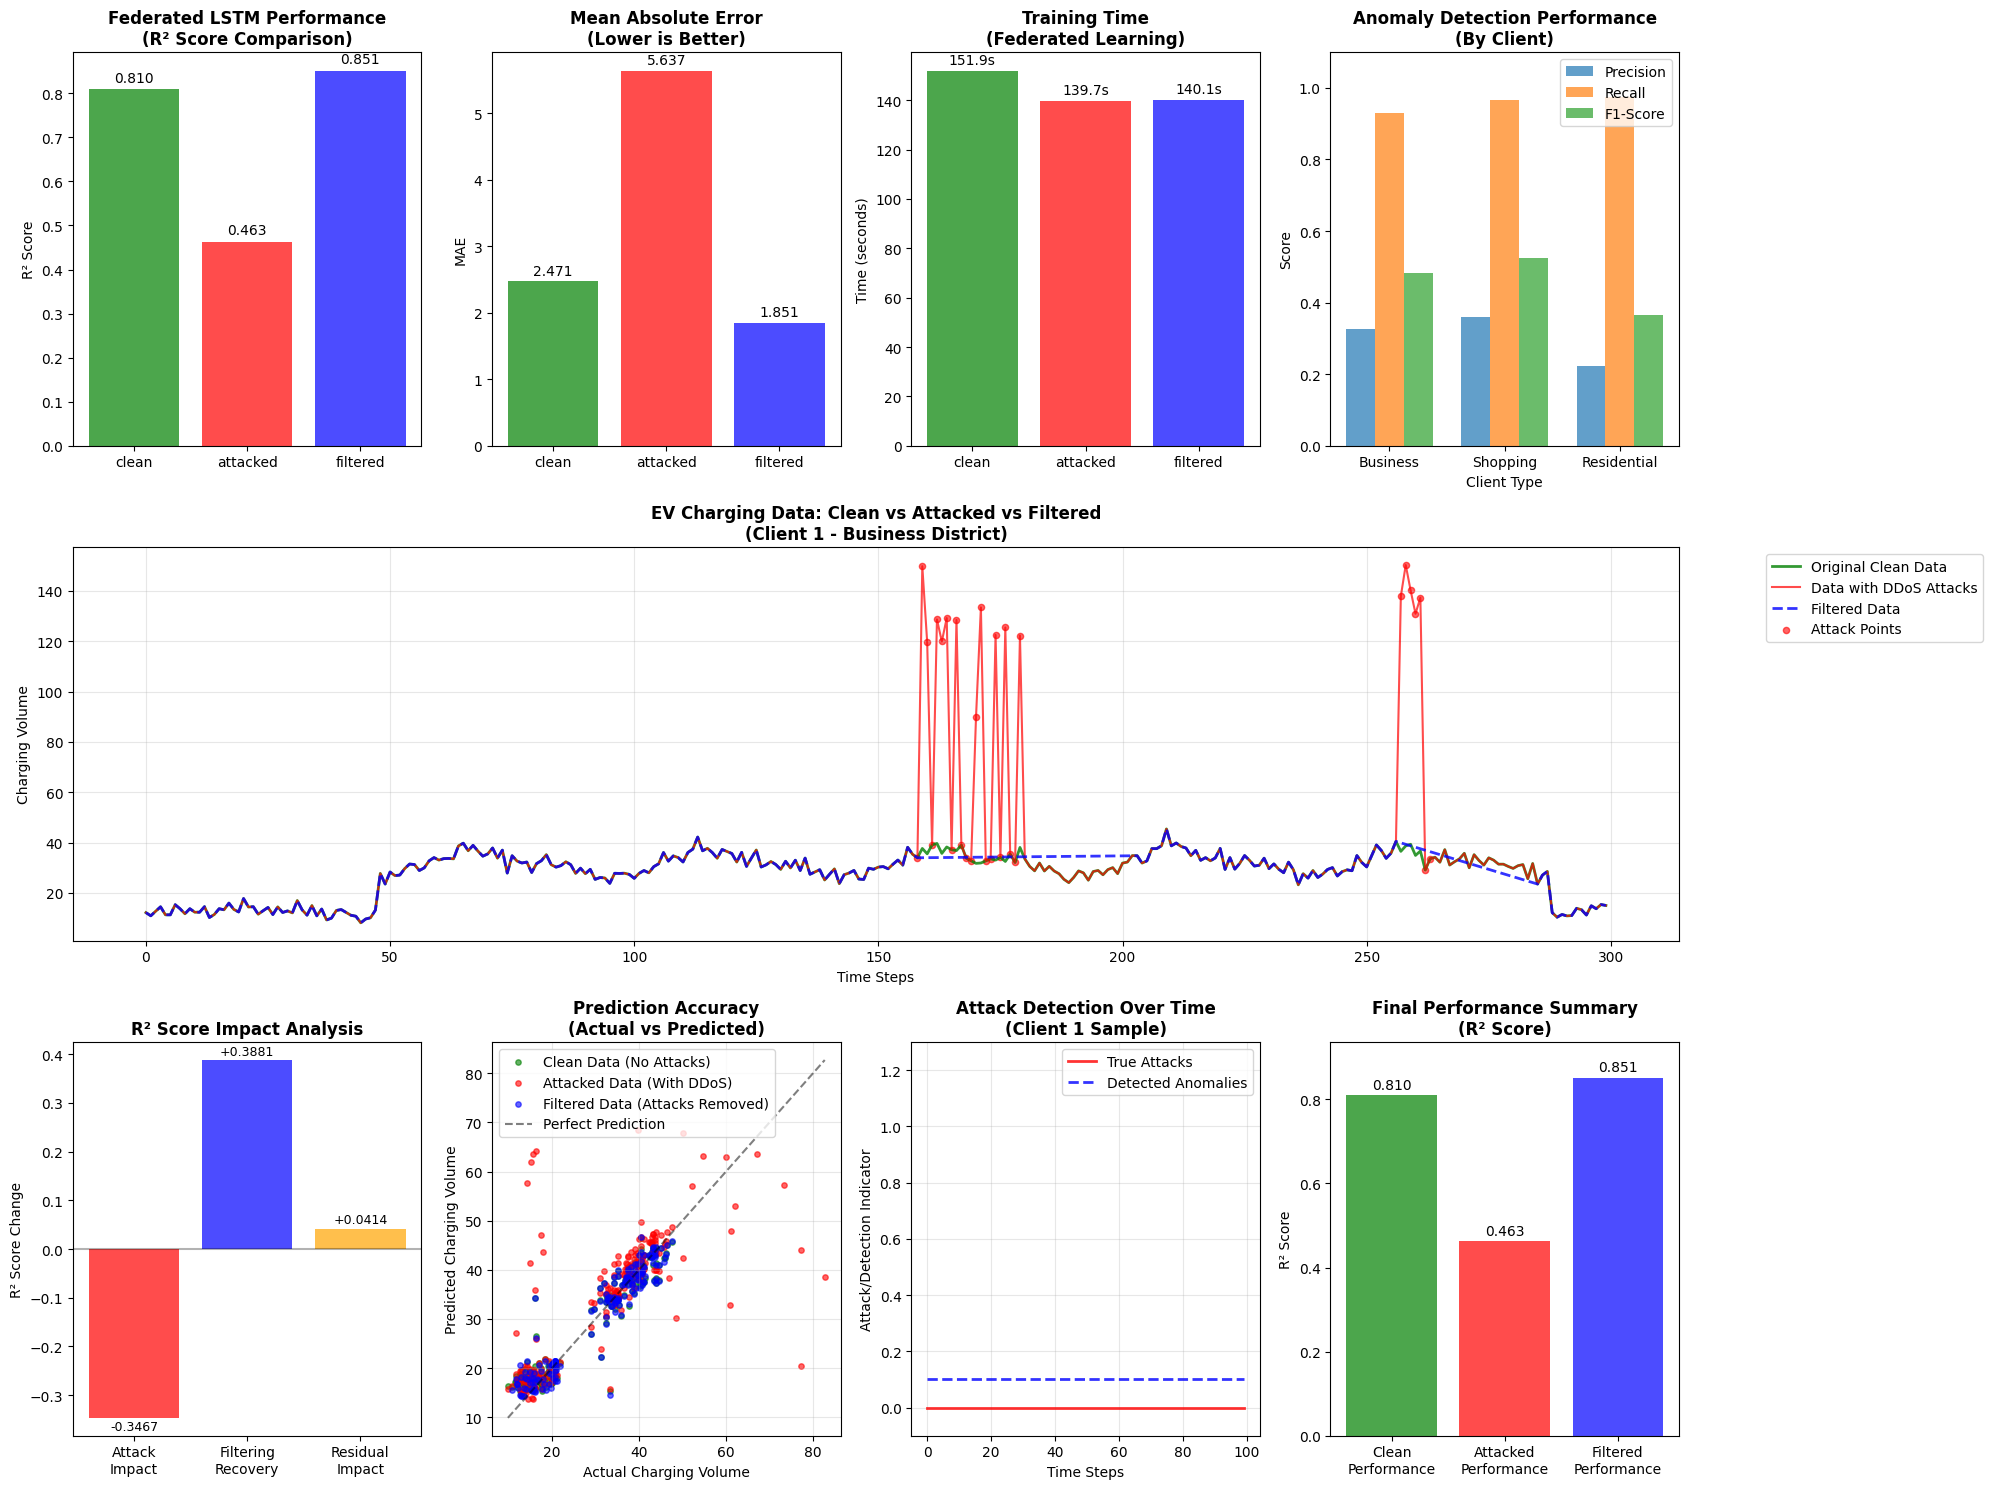

In [ ]:
 import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Input, RepeatVector, TimeDistributed
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import warnings
import time
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")
print(f"TensorFlow version: {tf.__version__}")

class EVChargingAnomalyFilter:
    def __init__(self, sequence_length=24, threshold_percentile=95):
        """
        LSTM Autoencoder for filtering DDoS attacks from EV charging data

        Args:
            sequence_length: Number of hours to look back (24 hours = 1 day)
            threshold_percentile: Percentile for anomaly threshold
        """
        self.sequence_length = sequence_length
        self.threshold_percentile = threshold_percentile
        self.scaler = MinMaxScaler()
        self.autoencoder = None
        self.threshold = None

    def create_sequences(self, data):
        """Create sequences for autoencoder training"""
        sequences = []
        for i in range(self.sequence_length, len(data)):
            sequences.append(data[i-self.sequence_length:i])
        return np.array(sequences)

    def build_autoencoder(self):
        """Build LSTM Autoencoder for anomaly detection"""
        print("Building LSTM Autoencoder...")

        # Input layer
        input_layer = Input(shape=(self.sequence_length, 1))

        # Encoder
        encoded = LSTM(50, activation='relu', return_sequences=True, dropout=0.2)(input_layer)
        encoded = LSTM(25, activation='relu', return_sequences=False, dropout=0.2)(encoded)

        # Decoder
        decoded = RepeatVector(self.sequence_length)(encoded)
        decoded = LSTM(25, activation='relu', return_sequences=True, dropout=0.2)(decoded)
        decoded = LSTM(50, activation='relu', return_sequences=True, dropout=0.2)(decoded)
        decoded = TimeDistributed(Dense(1))(decoded)

        # Create and compile model
        autoencoder = Model(input_layer, decoded)
        autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

        return autoencoder

    def train_autoencoder(self, normal_data):
        """Train autoencoder on normal (non-attack) data only"""
        print("Training autoencoder on normal data...")

        # Scale the data
        scaled_data = self.scaler.fit_transform(normal_data.reshape(-1, 1)).flatten()

        # Create sequences
        sequences = self.create_sequences(scaled_data)
        sequences = sequences.reshape(sequences.shape[0], sequences.shape[1], 1)

        # Build and train autoencoder
        self.autoencoder = self.build_autoencoder()

        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

        history = self.autoencoder.fit(
            sequences, sequences,
            epochs=50,
            batch_size=32,
            validation_split=0.2,
            callbacks=[early_stopping],
            verbose=1
        )

        # Calculate threshold
        predictions = self.autoencoder.predict(sequences, verbose=0)
        mse = np.mean(np.power(sequences - predictions, 2), axis=(1, 2))
        self.threshold = np.percentile(mse, self.threshold_percentile)

        print(f"Training completed. Anomaly threshold: {self.threshold:.6f}")

        return history

    def detect_anomalies(self, data):
        """Detect anomalies in the full dataset"""
        print("Detecting anomalies...")

        # Scale the data
        scaled_data = self.scaler.transform(data.reshape(-1, 1)).flatten()

        # Create sequences
        sequences = self.create_sequences(scaled_data)
        sequences = sequences.reshape(sequences.shape[0], sequences.shape[1], 1)

        # Get predictions and calculate reconstruction errors
        predictions = self.autoencoder.predict(sequences, verbose=0)
        mse = np.mean(np.power(sequences - predictions, 2), axis=(1, 2))

        # Identify anomalies
        anomalies = mse > self.threshold

        # Extend anomaly labels to match original data length
        anomaly_labels = np.zeros(len(data), dtype=bool)
        # The sequences start from index sequence_length-1
        anomaly_labels[self.sequence_length-1:self.sequence_length-1+len(anomalies)] = anomalies

        print(f"Detected {np.sum(anomaly_labels)} anomalous points out of {len(data)}")

        return anomaly_labels, mse

    def filter_anomalies(self, data, anomaly_labels):
        """Filter out anomalies using interpolation"""
        print("Filtering anomalies...")

        filtered_data = data.copy()

        # Find anomalous segments
        anomaly_indices = np.where(anomaly_labels)[0]

        if len(anomaly_indices) > 0:
            # Group consecutive anomalies
            anomaly_groups = []
            current_group = [anomaly_indices[0]]

            for i in range(1, len(anomaly_indices)):
                if anomaly_indices[i] - anomaly_indices[i-1] <= 2:  # Allow small gaps
                    current_group.append(anomaly_indices[i])
                else:
                    anomaly_groups.append(current_group)
                    current_group = [anomaly_indices[i]]
            anomaly_groups.append(current_group)

            # Interpolate each group
            for group in anomaly_groups:
                start_idx = max(0, group[0] - 1)
                end_idx = min(len(filtered_data), group[-1] + 2)

                # Create a mask for interpolation
                mask = np.ones(end_idx - start_idx, dtype=bool)
                mask[np.array(group) - start_idx] = False

                if np.sum(mask) >= 2:  # Need at least 2 points for interpolation
                    segment = filtered_data[start_idx:end_idx]
                    indices = np.arange(len(segment))

                    # Linear interpolation
                    filtered_data[group] = np.interp(
                        np.array(group) - start_idx,
                        indices[mask],
                        segment[mask]
                    )

        print(f"Filtered {len(anomaly_indices)} anomalous points")

        return filtered_data

def inject_ddos_attacks(data, attack_ratio=0.05, attack_intensity=3.0, min_attack_duration=6):
    """
    Inject DDoS-like attacks into EV charging data

    Args:
        data: Original charging volume data
        attack_ratio: Proportion of data affected by attacks
        attack_intensity: Multiplier for attack spikes
        min_attack_duration: Minimum duration of an attack in timesteps
    """
    print(f"Injecting DDoS attacks: {attack_ratio*100:.1f}% of data affected...")

    attacked_data = data.copy()
    attack_labels = np.zeros(len(data), dtype=bool)

    # Calculate number of attack points
    total_attack_points = int(len(data) * attack_ratio)

    # Ensure we have enough data for attacks
    if total_attack_points < min_attack_duration:
        print(f"Warning: Not enough data points for attacks. Need at least {min_attack_duration}, got {total_attack_points}")
        return attacked_data, attack_labels

    # Generate attack periods
    attacks_created = 0
    max_attempts = 100  # Prevent infinite loops
    attempts = 0

    while attacks_created < total_attack_points and attempts < max_attempts:
        attempts += 1

        # Ensure we have space for an attack
        if len(data) < min_attack_duration:
            break

        # Random start position (leave space for minimum duration)
        max_start = max(0, len(data) - min_attack_duration)
        if max_start <= 0:
            break
        start_pos = np.random.randint(0, max_start)

        # Calculate remaining points needed
        remaining_points = total_attack_points - attacks_created

        # Random attack duration - ensure high > low
        max_duration = min(24, remaining_points, len(data) - start_pos)
        if max_duration <= min_attack_duration:
            # If we can't fit a minimum duration attack, create one with remaining points
            duration = min(remaining_points, len(data) - start_pos)
        else:
            duration = np.random.randint(min_attack_duration, max_duration + 1)

        end_pos = min(start_pos + duration, len(data))

        # Skip if overlapping with existing attacks
        if np.any(attack_labels[start_pos:end_pos]):
            continue

        # Create irregular spikes pattern
        for i in range(start_pos, end_pos):
            # Variable intensity spikes
            spike_multiplier = attack_intensity * (0.8 + 0.4 * np.random.random())
            # Add some randomness to make it look like DDoS
            if np.random.random() > 0.3:  # 70% chance of spike
                attacked_data[i] *= spike_multiplier
            attack_labels[i] = True

        attacks_created += (end_pos - start_pos)

        # Break if we've created enough attacks
        if attacks_created >= total_attack_points:
            break

    actual_attack_ratio = np.sum(attack_labels) / len(data)
    print(f"Successfully injected {np.sum(attack_labels)} attack points ({actual_attack_ratio*100:.1f}% of data)")

    return attacked_data, attack_labels

def generate_ev_data(num_days=30, timesteps_per_hour=2, station_id=1):
    """Generate synthetic EV charging volume data with realistic patterns."""
    total_timesteps = num_days * 24 * timesteps_per_hour
    start_date = '2023-01-01'
    freq = f'{60//timesteps_per_hour}T'
    date_range = pd.date_range(start=start_date, periods=total_timesteps, freq=freq)

    base_volume = 20 + station_id * 5  # Base volume increases with station_id
    hours = np.array([dt.hour for dt in date_range])
    days_of_week = np.array([dt.weekday() for dt in date_range])
    days_of_year = np.array([dt.dayofyear for dt in date_range])

    # Base temporal patterns
    daily_pattern = 2 * np.sin(2 * np.pi * hours / 24 - np.pi/3)
    weekly_pattern = np.where(days_of_week < 5, 1.0, 0.7)
    seasonal_pattern = 1 + 0.2 * np.sin(2 * np.pi * days_of_year / 365)

    # Station-specific characteristics
    if station_id == 1:
        # Station 1: Business district
        daily_pattern += 1.8 * (np.exp(-((hours - 8)**2)/6) + np.exp(-((hours - 18)**2)/6))
        weekly_pattern = np.where(days_of_week < 5, 1.2, 0.5)
        station_variation = 1 + 0.15 * np.sin(2 * np.pi * days_of_year / 365)
        noise_scale = 0.08

    elif station_id == 2:
        # Station 2: Shopping center
        daily_pattern += 1.5 * np.exp(-((hours - 14)**2)/16)
        weekly_pattern = np.where(days_of_week >= 5, 1.3, 0.9)
        station_variation = 1 + 0.12 * np.cos(2 * np.pi * days_of_year / 365 + np.pi/4)
        noise_scale = 0.10

    else:  # station_id == 3
        # Station 3: Residential area
        daily_pattern += 2.0 * np.exp(-((hours - 20)**2)/10)
        weekly_pattern = np.ones_like(days_of_week) * 1.0
        station_variation = 1 + 0.18 * np.sin(2 * np.pi * days_of_year / 365 + np.pi/2)
        noise_scale = 0.06

    charging_volume = (
        base_volume *
        (1 + 0.25 * daily_pattern / 4) *
        weekly_pattern *
        seasonal_pattern *
        station_variation
    )

    noise = np.random.normal(0, base_volume * noise_scale, total_timesteps)
    charging_volume = np.maximum(charging_volume + noise, 1)

    df = pd.DataFrame({
        'datetime': date_range,
        'charging_volume': charging_volume
    })

    return df.set_index('datetime')

def create_sequences(data, sequence_length):
    """Create sequences for LSTM training."""
    X, y = [], []
    for i in range(sequence_length, len(data)):
        X.append(data[i-sequence_length:i])
        y.append(data[i])
    return np.array(X), np.array(y)

def create_lstm_model(sequence_length, lstm_units=20, learning_rate=0.001):
    """Create standard LSTM model for time series forecasting."""
    model = Sequential([
        LSTM(lstm_units, input_shape=(sequence_length, 1)),
        Dense(10, activation='relu'),
        Dense(1)
    ])

    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='mse', metrics=['mae'])
    return model

def federated_averaging(client_weights):
    """Perform federated averaging of client model weights."""
    avg_weights = []
    for layer_idx in range(len(client_weights[0])):
        layer_weights = np.mean([client[layer_idx] for client in client_weights], axis=0)
        avg_weights.append(layer_weights)
    return avg_weights

def evaluate_model(model, test_data, scaler, model_name):
    """Evaluate model performance and return comprehensive metrics."""
    X_test, y_test = test_data
    predictions_scaled = model.predict(X_test, verbose=0)

    predictions = scaler.inverse_transform(predictions_scaled)
    y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))

    mae = mean_absolute_error(y_test_original, predictions)
    rmse = np.sqrt(mean_squared_error(y_test_original, predictions))
    r2 = r2_score(y_test_original, predictions)

    print(f"{model_name}:")
    print(f"  MAE: {mae:.4f}, RMSE: {rmse:.4f}, R²: {r2:.4f}")

    return {
        'predictions': predictions.flatten(),
        'actual': y_test_original.flatten(),
        'mae': mae, 'rmse': rmse, 'r2': r2
    }

# Hyperparameters
NUM_DAYS = 180
TIMESTEPS_PER_HOUR = 2
SEQUENCE_LENGTH = 12
LSTM_UNITS = 20
EPOCHS_PER_ROUND = 5
FEDERATED_ROUNDS = 4
LEARNING_RATE = 0.001
TEST_SPLIT = 0.2

# Attack simulation parameters
ATTACK_RATIO = 0.08  # 8% of data affected by attacks
ATTACK_INTENSITY = 3.5  # Spike multiplier
MIN_ATTACK_DURATION = 6  # Minimum attack duration

print("🔋 ENHANCED EV FORECASTING: Anomaly Detection + Federated Learning")
print("🚨 Simulating DDoS attacks with sustained high volume irregular spikes")
print("🛡️ Comparing LSTM performance: Clean Data vs Anomalous Data vs Filtered Data")
print("=" * 90)

start_time = time.time()

# =============================================================================
# DATA GENERATION WITH DDOS ATTACKS
# =============================================================================
print("\n📊 Generating data for three EV charging stations with DDoS attacks...")

# Generate clean data
client1_clean = generate_ev_data(NUM_DAYS, TIMESTEPS_PER_HOUR, station_id=1)
client2_clean = generate_ev_data(NUM_DAYS, TIMESTEPS_PER_HOUR, station_id=2)
client3_clean = generate_ev_data(NUM_DAYS, TIMESTEPS_PER_HOUR, station_id=3)

# Inject DDoS attacks
client1_attacked, client1_attack_labels = inject_ddos_attacks(
    client1_clean['charging_volume'].values, ATTACK_RATIO, ATTACK_INTENSITY, MIN_ATTACK_DURATION)
client2_attacked, client2_attack_labels = inject_ddos_attacks(
    client2_clean['charging_volume'].values, ATTACK_RATIO, ATTACK_INTENSITY, MIN_ATTACK_DURATION)
client3_attacked, client3_attack_labels = inject_ddos_attacks(
    client3_clean['charging_volume'].values, ATTACK_RATIO, ATTACK_INTENSITY, MIN_ATTACK_DURATION)

# Create DataFrames for attacked data
client1_attacked_df = client1_clean.copy()
client1_attacked_df['charging_volume'] = client1_attacked
client2_attacked_df = client2_clean.copy()
client2_attacked_df['charging_volume'] = client2_attacked
client3_attacked_df = client3_clean.copy()
client3_attacked_df['charging_volume'] = client3_attacked

print(f"\n📈 Attack Statistics:")
print(f"  🏢 Client 1 (Business): {np.sum(client1_attack_labels)} attacked points ({np.sum(client1_attack_labels)/len(client1_attack_labels)*100:.1f}%)")
print(f"  🛒 Client 2 (Shopping): {np.sum(client2_attack_labels)} attacked points ({np.sum(client2_attack_labels)/len(client2_attack_labels)*100:.1f}%)")
print(f"  🏠 Client 3 (Residential): {np.sum(client3_attack_labels)} attacked points ({np.sum(client3_attack_labels)/len(client3_attack_labels)*100:.1f}%)")

# =============================================================================
# ANOMALY DETECTION AND FILTERING
# =============================================================================
print("\n🛡️ Training Anomaly Detection Models for Each Client...")

# Split data for training anomaly detectors (use clean portion of training data)
split_idx = int(len(client1_clean) * (1 - TEST_SPLIT))

# Initialize anomaly filters
filter1 = EVChargingAnomalyFilter(sequence_length=24, threshold_percentile=95)
filter2 = EVChargingAnomalyFilter(sequence_length=24, threshold_percentile=95)
filter3 = EVChargingAnomalyFilter(sequence_length=24, threshold_percentile=95)

# Train anomaly detectors on clean training data
print("Training Client 1 anomaly detector...")
filter1.train_autoencoder(client1_clean.iloc[:split_idx]['charging_volume'].values)

print("Training Client 2 anomaly detector...")
filter2.train_autoencoder(client2_clean.iloc[:split_idx]['charging_volume'].values)

print("Training Client 3 anomaly detector...")
filter3.train_autoencoder(client3_clean.iloc[:split_idx]['charging_volume'].values)

# Detect anomalies in attacked data
print("\n🔍 Detecting Anomalies in Attacked Data...")
client1_detected_anomalies, client1_mse = filter1.detect_anomalies(client1_attacked)
client2_detected_anomalies, client2_mse = filter2.detect_anomalies(client2_attacked)
client3_detected_anomalies, client3_mse = filter3.detect_anomalies(client3_attacked)

# Filter anomalies
print("\n🧹 Filtering Detected Anomalies...")
client1_filtered = filter1.filter_anomalies(client1_attacked, client1_detected_anomalies)
client2_filtered = filter2.filter_anomalies(client2_attacked, client2_detected_anomalies)
client3_filtered = filter3.filter_anomalies(client3_attacked, client3_detected_anomalies)

# Calculate detection accuracy
print("\n📊 Anomaly Detection Accuracy:")
for i, (true_labels, detected_labels, client_name) in enumerate([
    (client1_attack_labels, client1_detected_anomalies, "Client 1 (Business)"),
    (client2_attack_labels, client2_detected_anomalies, "Client 2 (Shopping)"),
    (client3_attack_labels, client3_detected_anomalies, "Client 3 (Residential)")
]):
    # Calculate detection metrics
    true_positives = np.sum(true_labels & detected_labels)
    false_positives = np.sum(~true_labels & detected_labels)
    false_negatives = np.sum(true_labels & ~detected_labels)

    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    print(f"  {client_name}: Precision={precision:.3f}, Recall={recall:.3f}, F1={f1_score:.3f}")

# =============================================================================
# PREPARE DATA FOR THREE SCENARIOS
# =============================================================================
print("\n📊 Preparing Data for Three Training Scenarios...")

scenarios = {
    'clean': {
        'data': [client1_clean, client2_clean, client3_clean],
        'name': 'Clean Data (No Attacks)'
    },
    'attacked': {
        'data': [client1_attacked_df, client2_attacked_df, client3_attacked_df],
        'name': 'Attacked Data (With DDoS)'
    },
    'filtered': {
        'data': [
            client1_clean.copy(),
            client2_clean.copy(),
            client3_clean.copy()
        ],
        'name': 'Filtered Data (Attacks Removed)'
    }
}

# Update filtered scenario with filtered data
scenarios['filtered']['data'][0]['charging_volume'] = client1_filtered
scenarios['filtered']['data'][1]['charging_volume'] = client2_filtered
scenarios['filtered']['data'][2]['charging_volume'] = client3_filtered

# =============================================================================
# TRAIN FEDERATED MODELS FOR EACH SCENARIO
# =============================================================================
results = {}

for scenario_name, scenario_data in scenarios.items():
    print(f"\n Training Federated LSTM for {scenario_data['name']}...")

    # Data splitting
    client_datasets = []
    scalers = []

    for client_data in scenario_data['data']:
        train_data = client_data.iloc[:split_idx]
        test_data = client_data.iloc[split_idx:]

        scaler = MinMaxScaler()
        train_scaled = scaler.fit_transform(train_data[['charging_volume']])
        test_scaled = scaler.transform(test_data[['charging_volume']])

        X_train, y_train = create_sequences(train_scaled.flatten(), SEQUENCE_LENGTH)
        X_test, y_test = create_sequences(test_scaled.flatten(), SEQUENCE_LENGTH)

        client_datasets.append({
            'X_train': X_train, 'y_train': y_train,
            'X_test': X_test, 'y_test': y_test
        })
        scalers.append(scaler)

    # Initialize federated models
    client_models = [
        create_lstm_model(SEQUENCE_LENGTH, LSTM_UNITS, LEARNING_RATE),
        create_lstm_model(SEQUENCE_LENGTH, LSTM_UNITS, LEARNING_RATE),
        create_lstm_model(SEQUENCE_LENGTH, LSTM_UNITS, LEARNING_RATE)
    ]

    # Federated training
    scenario_start = time.time()
    for round_num in range(FEDERATED_ROUNDS):
        print(f"  Round {round_num + 1}/{FEDERATED_ROUNDS}")

        # Local training
        for i, (model, dataset) in enumerate(zip(client_models, client_datasets)):
            model.fit(dataset['X_train'], dataset['y_train'],
                     epochs=EPOCHS_PER_ROUND, batch_size=16, verbose=0)

        # Federated averaging
        weights = [model.get_weights() for model in client_models]
        averaged_weights = federated_averaging(weights)

        for model in client_models:
            model.set_weights(averaged_weights)

    scenario_time = time.time() - scenario_start
    print(f"  ⏱️ Training time: {scenario_time:.2f}s")

    # Evaluate scenario
    all_predictions = []
    all_actual = []

    for i, (model, dataset, scaler) in enumerate(zip(client_models, client_datasets, scalers)):
        pred_scaled = model.predict(dataset['X_test'], verbose=0)
        predictions = scaler.inverse_transform(pred_scaled).flatten()
        actual = scaler.inverse_transform(dataset['y_test'].reshape(-1, 1)).flatten()

        all_predictions.extend(predictions)
        all_actual.extend(actual)

    # Calculate metrics
    mae = mean_absolute_error(all_actual, all_predictions)
    rmse = np.sqrt(mean_squared_error(all_actual, all_predictions))
    r2 = r2_score(all_actual, all_predictions)

    results[scenario_name] = {
        'mae': mae, 'rmse': rmse, 'r2': r2,
        'time': scenario_time,
        'predictions': all_predictions,
        'actual': all_actual
    }

    print(f"  Results: MAE={mae:.4f}, RMSE={rmse:.4f}, R²={r2:.4f}")

# =============================================================================
# COMPREHENSIVE ANALYSIS
# =============================================================================
total_time = time.time() - start_time

print("\n" + "="*90)
print(" COMPREHENSIVE ANALYSIS: Clean vs Attacked vs Filtered Data")
print("="*90)

print("\n🎯 FEDERATED LSTM PERFORMANCE COMPARISON:")
print("-" * 70)
print(f"{'Scenario':<25} {'MAE':<8} {'RMSE':<8} {'R²':<8} {'Time':<8}")
print("-" * 70)
for scenario_name, scenario_data in scenarios.items():
    result = results[scenario_name]
    print(f"{scenario_data['name']:<25} {result['mae']:<8.4f} {result['rmse']:<8.4f} {result['r2']:<8.4f} {result['time']:<8.1f}s")

print("\n IMPACT ANALYSIS:")
print("-" * 70)

# Compare attacked vs clean
attack_impact_r2 = results['clean']['r2'] - results['attacked']['r2']
attack_impact_percent = (attack_impact_r2 / results['clean']['r2']) * 100

print(f"Attack Impact on R² Score:           {attack_impact_r2:+.4f} ({attack_impact_percent:+.1f}%)")

# Compare filtered vs attacked
filtering_recovery_r2 = results['filtered']['r2'] - results['attacked']['r2']
filtering_recovery_percent = (filtering_recovery_r2 / attack_impact_r2) * 100 if attack_impact_r2 != 0 else 0

print(f"Filtering Recovery in R² Score:      {filtering_recovery_r2:+.4f} ({filtering_recovery_percent:+.1f}% of attack impact)")

# Compare filtered vs clean
residual_impact_r2 = results['clean']['r2'] - results['filtered']['r2']
residual_impact_percent = (residual_impact_r2 / results['clean']['r2']) * 100

print(f"Residual Impact after Filtering:     {residual_impact_r2:+.4f} ({residual_impact_percent:+.1f}%)")

print("\n ANOMALY DETECTION EFFECTIVENESS:")
print("-" * 70)

# Calculate overall detection metrics
total_true_attacks = np.sum(client1_attack_labels) + np.sum(client2_attack_labels) + np.sum(client3_attack_labels)
total_detected = np.sum(client1_detected_anomalies) + np.sum(client2_detected_anomalies) + np.sum(client3_detected_anomalies)

# Calculate combined metrics
all_true_labels = np.concatenate([client1_attack_labels, client2_attack_labels, client3_attack_labels])
all_detected_labels = np.concatenate([client1_detected_anomalies, client2_detected_anomalies, client3_detected_anomalies])

overall_tp = np.sum(all_true_labels & all_detected_labels)
overall_fp = np.sum(~all_true_labels & all_detected_labels)
overall_fn = np.sum(all_true_labels & ~all_detected_labels)

overall_precision = overall_tp / (overall_tp + overall_fp) if (overall_tp + overall_fp) > 0 else 0
overall_recall = overall_tp / (overall_tp + overall_fn) if (overall_tp + overall_fn) > 0 else 0
overall_f1 = 2 * (overall_precision * overall_recall) / (overall_precision + overall_recall) if (overall_precision + overall_recall) > 0 else 0

print(f"Overall Detection Precision:          {overall_precision:.3f}")
print(f"Overall Detection Recall:             {overall_recall:.3f}")
print(f"Overall Detection F1-Score:           {overall_f1:.3f}")
print(f"True Attacks Detected:                {overall_tp}/{total_true_attacks} ({overall_tp/total_true_attacks*100:.1f}%)")
print(f"False Positive Rate:                  {overall_fp/len(all_true_labels)*100:.2f}%")

# =============================================================================
# VISUALIZATION
# =============================================================================
plt.figure(figsize=(20, 15))

# Performance comparison
plt.subplot(3, 4, 1)
scenarios_names = list(scenarios.keys())
r2_scores = [results[name]['r2'] for name in scenarios_names]
colors = ['green', 'red', 'blue']

bars = plt.bar(scenarios_names, r2_scores, color=colors, alpha=0.7)
plt.title('Federated LSTM Performance\n(R² Score Comparison)', fontweight='bold')
plt.ylabel('R² Score')
for i, bar in enumerate(bars):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{r2_scores[i]:.3f}', ha='center', va='bottom', fontsize=10)

# MAE comparison
plt.subplot(3, 4, 2)
mae_scores = [results[name]['mae'] for name in scenarios_names]
bars = plt.bar(scenarios_names, mae_scores, color=colors, alpha=0.7)
plt.title('Mean Absolute Error\n(Lower is Better)', fontweight='bold')
plt.ylabel('MAE')
for i, bar in enumerate(bars):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(mae_scores)*0.01,
             f'{mae_scores[i]:.3f}', ha='center', va='bottom', fontsize=10)

# Training time comparison
plt.subplot(3, 4, 3)
training_times = [results[name]['time'] for name in scenarios_names]
bars = plt.bar(scenarios_names, training_times, color=colors, alpha=0.7)
plt.title('Training Time\n(Federated Learning)', fontweight='bold')
plt.ylabel('Time (seconds)')
for i, bar in enumerate(bars):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(training_times)*0.01,
             f'{training_times[i]:.1f}s', ha='center', va='bottom', fontsize=10)

# Anomaly detection accuracy
plt.subplot(3, 4, 4)
detection_metrics = ['Precision', 'Recall', 'F1-Score']
client_names = ['Business', 'Shopping', 'Residential']
metric_values = [
    [0, 0, 0],  # Will be filled with actual values
    [0, 0, 0],
    [0, 0, 0]
]

# Calculate metrics for each client
for i, (true_labels, detected_labels) in enumerate([
    (client1_attack_labels, client1_detected_anomalies),
    (client2_attack_labels, client2_detected_anomalies),
    (client3_attack_labels, client3_detected_anomalies)
]):
    tp = np.sum(true_labels & detected_labels)
    fp = np.sum(~true_labels & detected_labels)
    fn = np.sum(true_labels & ~detected_labels)

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    metric_values[0][i] = precision
    metric_values[1][i] = recall
    metric_values[2][i] = f1

x_pos = np.arange(len(client_names))
width = 0.25

for i, metric in enumerate(detection_metrics):
    plt.bar(x_pos + i*width, metric_values[i], width,
           label=metric, alpha=0.7)

plt.title('Anomaly Detection Performance\n(By Client)', fontweight='bold')
plt.xlabel('Client Type')
plt.ylabel('Score')
plt.xticks(x_pos + width, client_names)
plt.legend()
plt.ylim(0, 1.1)

# Sample time series visualization (Client 1)
plt.subplot(3, 4, (5, 8))
sample_length = min(300, len(client1_clean))
sample_indices = range(sample_length)

# Plot original, attacked, and filtered data
plt.plot(sample_indices, client1_clean.iloc[:sample_length]['charging_volume'].values,
         'g-', label='Original Clean Data', linewidth=2, alpha=0.8)
plt.plot(sample_indices, client1_attacked[:sample_length],
         'r-', label='Data with DDoS Attacks', linewidth=1.5, alpha=0.7)
plt.plot(sample_indices, client1_filtered[:sample_length],
         'b--', label='Filtered Data', linewidth=2, alpha=0.8)

# Highlight attack periods
attack_periods = client1_attack_labels[:sample_length]
attack_indices = np.where(attack_periods)[0]
if len(attack_indices) > 0:
    plt.scatter(attack_indices, client1_attacked[attack_indices],
               c='red', s=20, alpha=0.6, label='Attack Points')

plt.title('EV Charging Data: Clean vs Attacked vs Filtered\n(Client 1 - Business District)',
          fontsize=12, fontweight='bold')
plt.xlabel('Time Steps')
plt.ylabel('Charging Volume')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)

# Impact analysis visualization
plt.subplot(3, 4, 9)
impact_categories = ['Attack\nImpact', 'Filtering\nRecovery', 'Residual\nImpact']
impact_values = [
    -attack_impact_r2,  # Negative because it's a loss
    filtering_recovery_r2,  # Positive because it's a recovery
    -residual_impact_r2  # Negative because it's still a loss
]
impact_colors = ['red', 'blue', 'orange']

bars = plt.bar(impact_categories, impact_values, color=impact_colors, alpha=0.7)
plt.title('R² Score Impact Analysis', fontweight='bold')
plt.ylabel('R² Score Change')
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)

for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + (0.005 if height >= 0 else -0.005),
             f'{impact_values[i]:+.4f}', ha='center',
             va='bottom' if height >= 0 else 'top', fontsize=9)

# Prediction accuracy scatter plot
plt.subplot(3, 4, 10)
sample_size = min(200, len(results['clean']['actual']))
for scenario_name, color in zip(scenarios_names, colors):
    actual_sample = results[scenario_name]['actual'][:sample_size]
    pred_sample = results[scenario_name]['predictions'][:sample_size]
    plt.scatter(actual_sample, pred_sample, c=color, alpha=0.6,
               label=scenarios[scenario_name]['name'], s=15)

# Perfect prediction line
min_val = min([min(results[name]['actual'][:sample_size]) for name in scenarios_names])
max_val = max([max(results[name]['actual'][:sample_size]) for name in scenarios_names])
plt.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5, label='Perfect Prediction')

plt.title('Prediction Accuracy\n(Actual vs Predicted)', fontweight='bold')
plt.xlabel('Actual Charging Volume')
plt.ylabel('Predicted Charging Volume')
plt.legend()
plt.grid(True, alpha=0.3)

# Detection effectiveness over time
plt.subplot(3, 4, 11)
# Show detection effectiveness as a time series for Client 1
detection_window = 100
if len(client1_attack_labels) >= detection_window:
    time_indices = range(detection_window)
    true_attacks_window = client1_attack_labels[:detection_window]
    detected_attacks_window = client1_detected_anomalies[:detection_window]

    plt.plot(time_indices, true_attacks_window.astype(int), 'r-',
             label='True Attacks', linewidth=2, alpha=0.8)
    plt.plot(time_indices, detected_attacks_window.astype(int) + 0.1, 'b--',
             label='Detected Anomalies', linewidth=2, alpha=0.8)

    plt.title('Attack Detection Over Time\n(Client 1 Sample)', fontweight='bold')
    plt.xlabel('Time Steps')
    plt.ylabel('Attack/Detection Indicator')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.ylim(-0.1, 1.3)

# Overall effectiveness summary
plt.subplot(3, 4, 12)
effectiveness_metrics = ['Clean\nPerformance', 'Attacked\nPerformance', 'Filtered\nPerformance']
effectiveness_values = [results['clean']['r2'], results['attacked']['r2'], results['filtered']['r2']]
colors_eff = ['green', 'red', 'blue']

bars = plt.bar(effectiveness_metrics, effectiveness_values, color=colors_eff, alpha=0.7)
plt.title('Final Performance Summary\n(R² Score)', fontweight='bold')
plt.ylabel('R² Score')
plt.ylim(0, max(effectiveness_values) * 1.1)

for i, bar in enumerate(bars):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(effectiveness_values)*0.01,
             f'{effectiveness_values[i]:.3f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()
